In [3]:
import os
import pandas
import pathlib
import numpy
import collections
import abc
import numpy.typing

In [324]:
%%html
<!-- Disable line wrapping in cell outputs to make the output more readable -->
<style>
div.jp-OutputArea-output pre {
    white-space: pre;
}
</style>

# Generate data (not needed if loading data)

In [4]:
os.chdir("..")

In [5]:
import pandas
import functools
from typing import Mapping, Callable
from util import flatten1
from prov_collectors import PROV_COLLECTORS
from workloads import WORKLOADS
import operator

rel_qois = ["cputime", "walltime", "memory"]
abs_qois = ["storage", "n_ops", "n_unique_files"]
output = pathlib.Path("output")
output.mkdir(exist_ok=True)

In [364]:
from experiment import get_results
from workloads import WORKLOAD_GROUPS
from prov_collectors import PROV_COLLECTOR_GROUPS
from util import flatten1

collectors = list(flatten1([
    PROV_COLLECTOR_GROUPS[collector_name]
    for collector_name in ["fast"]
]))
workloads = list(flatten1([
    WORKLOAD_GROUPS[workload_name]
    for workload_name in ["working"]
]))
iterations = 5
ignore_failures = True
rerun = False
df = get_results(
    collectors,
    workloads,
    iterations=iterations,
    seed=0,
    ignore_failures=ignore_failures,
    rerun=rerun,
)

In [365]:
agged = (
    df
    .groupby(["collector", "workload"], observed=True, as_index=True)
    .agg(**{
        **{
            f"{qoi}_std": pandas.NamedAgg(qoi, "std")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_mean": pandas.NamedAgg(qoi, "mean")
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_low": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 5))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_high": pandas.NamedAgg(qoi, lambda data: numpy.percentile(data, 95))
            for qoi in abs_qois + rel_qois
        },
        **{
            f"{qoi}_sorted": pandas.NamedAgg(qoi, lambda data: list(sorted(data)))
            for qoi in abs_qois + rel_qois
        },
        "op_type_counts_sum": pandas.NamedAgg("op_type_counts", lambda op_type_freqs: functools.reduce(operator.add, op_type_freqs, collections.Counter())),
        "count": pandas.NamedAgg("walltime", lambda walltimes: len(walltimes)),
    })
    .assign(**{
        **{
            f"{qoi}_rel": lambda df, qoi=qoi: df[f"{qoi}_std"] / df[f"{qoi}_mean"]
            for qoi in abs_qois + rel_qois
        },
        "rel_slowdown": lambda df: df["walltime_mean"] / df.loc["noprov"]["walltime_mean"],
    })
    .assign(**{
        "log_rel_slowdown": lambda df: numpy.log(df["rel_slowdown"]),
    })
)

## Feature engineering

In [366]:
import collections
all_syscalls = collections.Counter()
for counter in df[df["collector"] == "strace"]["op_type_counts"]:
    all_syscalls += counter
all_syscalls

Counter({'newfstatat': 21281977,
         'close': 10098152,
         'openat': 8988023,
         'unlink': 2500908,
         'creat': 2159312,
         'readlink': 1820386,
         'utimensat': 1316414,
         'exit_group': 446508,
         'clone': 438986,
         'access': 322197,
         'execve': 237976,
         'connect': 80159,
         'mkdirat': 75016,
         'dup2': 35630,
         'mkdir': 32808,
         'rmdir': 28613,
         'clone3': 24508,
         'pipe2': 20851,
         'rename': 20199,
         'exit': 18732,
         'chdir': 14000,
         'vfork': 8240,
         'accept': 4435,
         'chmod': 4399,
         'fchmod': 3837,
         'dup': 3733,
         'bind': 3483,
         'symlink': 855,
         'accept4': 30,
         'link': 15,
         'ftruncate': 11})

In [367]:
syscall_groups = {
    "socket": {"accept4", "connect", "bind", "accept"},
    "file": {"newfstatat", "readlink", "access", "chmod", "fchmod", "mkdir", "rmdir", "mkdirat", "rename", "unlink", "link", "symlink"},
    "fd": {"creat", "open", "openat"},
    "clone": {"clone", "clone3"},
    "fork": {"vfork"},
    "exec": {"clone", "clone3"},
}
syscall_groups["other"] = {
    syscall
    for syscall in all_syscalls
    if not any(syscall in group for group in syscall_groups.values())
}
syscall_groups

{'socket': {'accept', 'accept4', 'bind', 'connect'},
 'file': {'access',
  'chmod',
  'fchmod',
  'link',
  'mkdir',
  'mkdirat',
  'newfstatat',
  'readlink',
  'rename',
  'rmdir',
  'symlink',
  'unlink'},
 'fd': {'creat', 'open', 'openat'},
 'clone': {'clone', 'clone3'},
 'fork': {'vfork'},
 'exec': {'clone', 'clone3'},
 'other': {'chdir',
  'close',
  'dup',
  'dup2',
  'execve',
  'exit',
  'exit_group',
  'ftruncate',
  'pipe2',
  'utimensat'}}

In [368]:
syscall_groups = {
    "socket": {"accept4", "connect", "bind", "accept"},
    "metadata": {"newfstatat", "access"},
    "chmod": {"chmod", "fchmod"},
    "dir": {"mkdir", "rmdir", "mkdirat", "rename", "unlink", "link", "readlink", "symlink"},
    "file": {"creat", "open", "openat"},
    "exec": {"execve", "vfork"},
    "clone": {"clone", "clone3"},
    "exits": {"exit", "exit_group"},
    "dups": {"dup", "dup2"},
}
syscall_groups["other"] = {
    syscall
    for syscall in all_syscalls
    if not any(syscall in group for group in syscall_groups.values())
}
syscall_groups

{'socket': {'accept', 'accept4', 'bind', 'connect'},
 'metadata': {'access', 'newfstatat'},
 'chmod': {'chmod', 'fchmod'},
 'dir': {'link',
  'mkdir',
  'mkdirat',
  'readlink',
  'rename',
  'rmdir',
  'symlink',
  'unlink'},
 'file': {'creat', 'open', 'openat'},
 'exec': {'execve', 'vfork'},
 'clone': {'clone', 'clone3'},
 'exits': {'exit', 'exit_group'},
 'dups': {'dup', 'dup2'},
 'other': {'chdir', 'close', 'ftruncate', 'pipe2', 'utimensat'}}

In [369]:
noprov = agged.loc["noprov"]
strace = agged.loc["strace"]
features_df = pandas.DataFrame({
    "cputime_per_sec": noprov["cputime_mean"] / noprov["walltime_mean"],
    "memory_mean": noprov["memory_mean"],
    **{
        group_name + "_syscalls_per_sec": strace["op_type_counts_sum"].map(lambda op_type_counts: sum(
            op_type_counts[syscall_name]
            for syscall_name in syscall_names
        )) / (noprov["walltime_mean"] * noprov["count"])
        for group_name, syscall_names in syscall_groups.items()
    },
    "n_ops_per_sec": strace["n_ops_mean"] / noprov["walltime_mean"],
})
features_df

,cputime_per_sec,memory_mean,socket_syscalls_per_sec,metadata_syscalls_per_sec,chmod_syscalls_per_sec,dir_syscalls_per_sec,file_syscalls_per_sec,exec_syscalls_per_sec,clone_syscalls_per_sec,exits_syscalls_per_sec,dups_syscalls_per_sec,other_syscalls_per_sec,n_ops_per_sec
workload,,,,,,,,,,,,,
a-data-sci,1.656835,453953126.4,1.617302,2067.889982,0.094029,1.692525,819.455002,5.086979,1.372826,1.278797,1.269394,537.809364,3437.566202
archive,0.641781,8740044.8,308.263700,126472.467823,0.000000,0.000000,42888.529226,78.216163,77.449338,78.676258,0.766825,41653.173951,211557.543283
archive bzip2,1.012005,9306112.0,18.142822,3848.589054,0.000000,0.000000,1382.342931,9.049049,4.546886,4.666149,7.304834,1278.167053,6552.808779
archive gzip,1.032715,3735552.0,87.599999,14930.548022,0.000000,0.000000,5335.372905,42.118369,17.350974,17.488954,37.237330,4989.353771,25457.070325
archive pbzip2,5.808363,53924659.2,52.994439,10837.842980,0.000000,0.000000,3982.058090,25.432319,81.642339,84.941441,19.502288,3624.794556,18709.208451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
unarchive bzip2,1.081077,14749696.0,27.784051,3947.201301,0.000000,207.343662,3714.810524,13.974963,13.892025,14.113192,13.905848,7225.760760,15178.786327
unarchive gzip,0.996824,11327897.6,114.568192,11133.744526,0.000000,570.937835,10307.445229,57.474409,38.252835,38.785710,57.360221,20081.748708,42400.317664
unarchive pbzip2,3.274150,40724889.6,54.951379,7138.378002,0.000000,368.535018,6825.383391,24.812793,159.651058,205.398879,24.714622,12956.057657,27757.882799


## Actually creating Numpy arrays

In [370]:
tmp_df = agged.reset_index().pivot(index="collector", columns="workload", values="log_rel_slowdown")
noprov_index = list(agged.index.levels[0]).index("noprov")
strace_index = list(agged.index.levels[0]).index("strace")

assert all(
    workload0 == workload1
    for workload0, workload1 in zip(tmp_df.columns, features_df.index)
)

systems_by_benchmarks = tmp_df.values
benchmarks_by_features = features_df.values


collector_names = list(agged.index.levels[0])
benchmark_names = list(agged.index.levels[1])
feature_names = list(features_df.columns)


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape

```python
systems_by_benchmarks = numpy.load("systems_by_benchmarks.npy")
benchmarks_by_features = numpy.load("benchmarks_by_features.npy")
collector_names = pathlib.Path("collectors.txt").read_text().split("\n")
benchmark_names = pathlib.Path("benchmark_names.txt").read_text().split("\n")
feature_names = pathlib.Path("feature_names.txt").read_text().split("\n")


n_systems, n_benchmarks = systems_by_benchmarks.shape
_, n_features = benchmarks_by_features.shape
```

# Let's play the new system game

It is more of a dialogue.

- **Given** integer N, workloads x benchmarks, and benchmarks x features matrix
- **Select** select N workloads and other parameters
- **Given** new system's log slowdown ratio on N selected workloads. This represents a hypothetical read of my publication who wants to test there system, but doesn't have the time to run all ~100s of benchmarks.
- **Predict** predict new system's log slowdown ratio on all other workloads

I initially scored this game by cross-validated root-mean-squared-error. However, I've found that even with cross-validation, more complex models are not "punished" enough. So I decided to also include Akaike Information Criterion (modified for small sample size). But in order to compute the AIC, one has to know the likelihood function. If you're lazy, your model has uninformitave priors, and your errors are normally distributed (although with unknown variance), you can use `naive_log_likelihood`, which computes the likelihood-maximizing variance, and returns the likelihood of the data based on that.

In [400]:
class NewSystemPredictor:
    @abc.abstractmethod
    def select_benchmarks(
        self,
        k: int,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark

        returns a tuple containing:
          - k benchmarks to select
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.
        """

    @abc.abstractmethod
    def predict_new_system(
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        """
        new_system_by_selected_benchmarks: array where the (g,p)th element is the log of the gth new system's slowdown on the pth *selected* benchmark

        returns an array where the (g,q)th element is the log of the gth new system's slowdown on the qth *unselected* benchmark
        """

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

Assume a model predicts $\hat{r}_i = f(r_i) + \eta_i$ where $\eta_i$ is normally distributed around 0 with unknown variance.

Let's find the variance which maximizes likelihood.

First, I'll write down the PDF (which is likelihood function) for the Normal distribution, where $\mu$ is the prediction and $x$ is the observation:

$$ f(x | \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left(-\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 \right) $$

Then log both sides.

$$\log f(x | \mu, \sigma) = -\log(\sigma \sqrt{2\pi}) - \frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 $$

In order to maximize, take a derivative with $\sigma$.

$$\frac{d}{d\sigma} \log f(x | \mu, \sigma) = -\frac{1}{\sigma} + \frac{(x - \mu)^2}{\sigma^3} $$

Set that to zero.

$$0 = \frac{d}{d\sigma} \log f(x | \mu, \sigma) \implies \frac{1}{\sigma} = \frac{(x - \mu)^2}{\sigma^3} \implies \sigma = |x - \mu|$$

Therefore $\log f(x | \mu, \sigma)$ has a maximum at $\sigma = |x - \mu|$.

We can plug that back in to the log-likelihood function.

In [373]:
def naive_log_likelihood(actual, predicted) -> float:
    std = numpy.clip(numpy.mean(numpy.fabs(actual - predicted)), 1e-2, None)
    # Some of the values we hit "dead-on"
    # This predicts the sigma should be 0, which is wrong
    # It should actually be a small positive number.
    
    # Plugging this in to the log PDF above
    return numpy.sum(-1/2*((actual - predicted)/std)**2 - numpy.log(std) + 1/2*numpy.log(2*numpy.pi))

In [374]:
import scipy.linalg.interpolative

class InitialSystemPredictor(NewSystemPredictor):
    """
    This is a simple predictor just to test the mechanics.

    It simply selects self.benchmarks.
    Then it runs a regression to all the unselected benchmarks based on the selected benchmarks.
    That's it.

    Note this method will overesimate the "goodness" in cross-validation,
    if feature-selection (input to __init__) is determined by the whole dataset, not just the train dataset.
    """
    def __init__(self, benchmarks: list[int]) -> None:
        self.benchmarks = benchmarks

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.benchmarks!r})"

In [381]:
import scipy.linalg.interpolative

class InterpolativeDecompositionSystemPredictor(NewSystemPredictor):
    """
    This method uses Interpolative Decomposition (ID).

    ID factors a matrix A into B @ C.
    It selects k columns of A, and puts those in B.
    It puts the identity matrix in the corresponding columns of C.
    The remaining N - k columns of A are predicted from a linear regression on the k columns of A (equivalently, all the columns of B).

    This method should be pretty good.
    """
    def __init__(self, k: int, use_features: bool) -> None:
        self.k = k
        self.use_features = use_features

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        if self.use_features:
            data = numpy.vstack([
                systems_by_benchmarks,
                benchmarks_by_features.T,
            ])
        else:
            data = systems_by_benchmarks
        idx, proj = scipy.linalg.interpolative.interp_decomp(data, self.k, rand=False)
        self.idx = idx
        self.proj = proj
        # skel = scipy.linalg.interpolative.reconstruct_skel_matrix(data, self.k, idx)
        # data_est = scipy.linalg.interpolative.reconstruct_matrix_from_id(skel, idx, proj)[:len(systems_by_benchmarks), :]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, self.idx[self.k:]],
            self.predict_new_systems(systems_by_benchmarks[:, self.idx[:self.k]]),
        )
        return idx[:self.k], log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.proj

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.proj.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.k}, {self.use_features})"

In [416]:
import sklearn.decomposition
import sklearn.cluster

class ClusteringSystemPredictor(NewSystemPredictor):
    def __init__(self, k: int, use_features: bool, whiten: bool) -> None:
        self.k = k
        self.use_features = use_features
        self.whiten = whiten

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        if self.use_features:
            data = numpy.vstack([
                systems_by_benchmarks,
                benchmarks_by_features.T,
            ])
        else:
            data = systems_by_benchmarks
        self.pca = sklearn.decomposition.PCA(
            whiten=self.whiten,
            random_state=0,
        )
        self.rotated_data = self.pca.fit_transform(data.T)
        self.kmeans = sklearn.cluster.KMeans(n_clusters=self.k, random_state=0, n_init=1)
        self.kmeans.fit(self.rotated_data)
        self.benchmarks = [
            min(
                range(benchmarks_by_features.shape[0]),
                key=lambda benchmark: scipy.spatial.distance.euclidean(self.rotated_data[benchmark], cluster_center),
            )
            for cluster_center in self.kmeans.cluster_centers_
        ]
        assert len(set(self.benchmarks)) == self.k, (
            "Somehow, we chose fewer benchmarks than expected;"
            "this can happen if one benchmark is the closest to two different cluster centrs"
        )
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def plot(self, ax: "maptloltib.axes.Axes") -> None:
        import matplotlib.cm
        colors = sorted(matplotlib.cm.Dark2.colors + matplotlib.cm.Set2.colors)
        for i in range(len(self.rotated_data)):
            ax.plot(
                self.rotated_data[i, 0],
                self.rotated_data[i, 1], 
                color=colors[self.kmeans.labels_[i]],
                marker=".",
                markersize=2,
            )
        for cluster_label, benchmark in enumerate(self.benchmarks):
            ax.plot(
                self.rotated_data[benchmark, 0],
                self.rotated_data[benchmark, 1],
                color=(*colors[cluster_label][:3], 0.6),
                marker="x",
                markersize=5,
                markeredgewidth=2,
            )
        for cluster_label, cluster_center in enumerate(self.kmeans.cluster_centers_):
            ax.plot(
                cluster_center[0],
                cluster_center[1], 
                color=(*colors[cluster_label][:3], 0.6),
                marker="x",
                markersize=15,
                markeredgewidth=2,
            )
        ax.legend(handles=[
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.6), linestyle="", marker="x", markersize=15, markeredgewidth=2, label="cluster center"),
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 0.6), linestyle="", marker="x", markersize=5, markeredgewidth=2, label="chosen benchmark"),
            matplotlib.lines.Line2D([0], [0], color=(0, 0, 0, 1), linestyle="", marker=".", markersize=2, label="benchmark"),
        ])

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.k}, {self.use_features}, {self.whiten})"

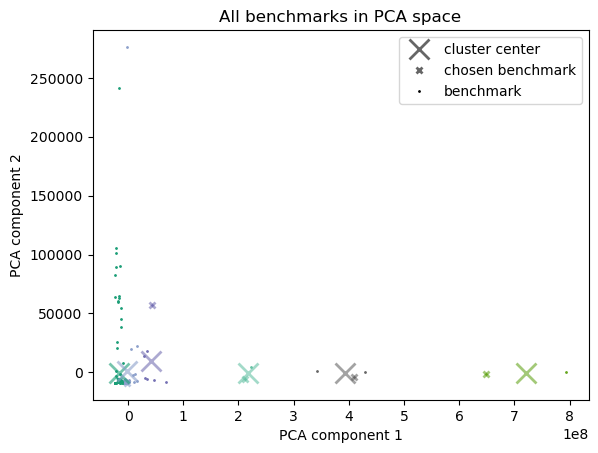

In [420]:
import matplotlib.pyplot
%matplotlib inline
pred = ClusteringSystemPredictor(6, True, False)
pred.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("All benchmarks in PCA space")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
pred.plot(ax)

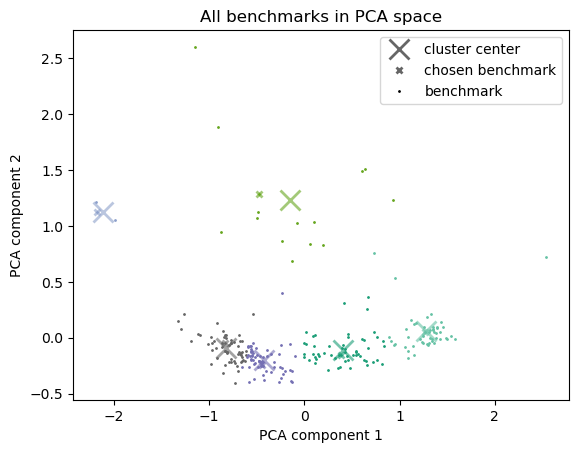

In [421]:
import matplotlib.pyplot
%matplotlib inline
pred = ClusteringSystemPredictor(6, False, False)
pred.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("All benchmarks in PCA space")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
pred.plot(ax)

In [383]:
class BestFeaturePredictor(NewSystemPredictor):
    """
    First, find the best features to use to predict benchmarks.
    Second, find the tests which best optimize those features.
    """
    def __init__(self, n_benchmarks: int, nth_place: int) -> None:
        self.n_benchmarks = n_benchmarks
        self.nth_place = nth_place

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        pred = BestOfNMatrixFactorization(self.n_benchmarks, 50)
        pred.predict_new_benchmark(
            systems_by_benchmarks,
            benchmarks_by_features,
            benchmarks_by_features,
        )
        features = pred.get_important_features()
        self.benchmarks = (
            benchmarks_by_features
            [:, features]
            .sum(axis=1)
            .argsort()
            [self.nth_place:(self.nth_place + self.n_benchmarks)]
        )
        unselected_benchmarks = [
            benchmark
            for benchmark in range(systems_by_benchmarks.shape[1])
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, self.benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        # the selected benchmarks will get probability = 1, log likelihood = 0, so you can imagine I wrote ... + 0 + 0 + 0 to the end
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        # add one for the stddev of errors computed by naive_log_likelhiood
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.n_benchmarks}, {self.nth_place})"

In [393]:
import random

class BestOfNBenchmarkSelector(NewSystemPredictor):
    """
    First, find the best features to use to predict benchmarks.
    Second, find the tests which best optimize those features.
    """
    def __init__(self, n_benchmarks: int, n_iters: int) -> None:
        self.n_benchmarks = n_benchmarks
        self.n_iters = n_iters

    def select_benchmarks(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        best_benchmarks = None
        best_score = None
        rng = random.Random(0)
        benchmarks = list(range(benchmarks_by_features.shape[0]))
        for _ in range(self.n_iters):
            candidate_benchmarks = rng.sample(benchmarks, self.n_benchmarks)
            unselected_benchmarks = [
                benchmark
                for benchmark in benchmarks
                if benchmark not in candidate_benchmarks
            ]
            score = numpy.sum((systems_by_benchmarks[:, candidate_benchmarks] @ (
                numpy.linalg.pinv(systems_by_benchmarks[:, candidate_benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
            ) - systems_by_benchmarks[:, unselected_benchmarks])**2)
            if best_score is None or score < best_score:
                best_score = score
                best_benchmarks = candidate_benchmarks
        self.benchmarks = best_benchmarks
        unselected_benchmarks = [
            benchmark
            for benchmark in benchmarks
            if benchmark not in self.benchmarks
        ]
        self.coeffs = numpy.linalg.pinv(systems_by_benchmarks[:, candidate_benchmarks]) @ systems_by_benchmarks[:, unselected_benchmarks]
        log_likelihood = naive_log_likelihood(
            systems_by_benchmarks[:, unselected_benchmarks],
            systems_by_benchmarks[:, self.benchmarks] @ self.coeffs,
        )
        return self.benchmarks, log_likelihood

    def predict_new_systems(
        self,
        new_systems_by_selected_benchmarks: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        return new_systems_by_selected_benchmarks @ self.coeffs

    def n_parameters(self) -> int:
        return len(self.coeffs.flatten()) + 1

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.n_benchmarks})"

In [394]:
features_df.sort_values("cputime_per_sec").tail()

,cputime_per_sec,memory_mean,socket_syscalls_per_sec,metadata_syscalls_per_sec,chmod_syscalls_per_sec,dir_syscalls_per_sec,file_syscalls_per_sec,exec_syscalls_per_sec,clone_syscalls_per_sec,exits_syscalls_per_sec,dups_syscalls_per_sec,other_syscalls_per_sec,n_ops_per_sec
workload,,,,,,,,,,,,,
a-data-sci,1.656835,453953126.4,1.617302,2067.889982,0.094029,1.692525,819.455002,5.086979,1.372826,1.278797,1.269394,537.809364,3437.566202
bw_unix,1.953688,1857945.6,0.000000,1.074266,0.000000,0.000000,1.332090,0.042971,0.085941,0.085941,0.000000,1.607102,4.228312
unarchive pbzip2,3.274150,40724889.6,54.951379,7138.378002,0.000000,368.535018,6825.383391,24.812793,159.651058,205.398879,24.714622,12956.057657,27757.882799
archive pbzip2,5.808363,53924659.2,52.994439,10837.842980,0.000000,0.000000,3982.058090,25.432319,81.642339,84.941441,19.502288,3624.794556,18709.208451
archive pigz,6.345669,9711616.0,218.424752,49119.289523,0.000000,0.000000,17664.121339,108.782970,373.125586,415.493689,94.125896,16415.693628,84409.057383


In [409]:
import sklearn.model_selection


mean_absolute_error = lambda a, b: numpy.mean(numpy.fabs(a - b))

root_mean_squared_error = lambda a, b: numpy.sqrt(numpy.mean((a-b)**2))


def aicc(k: int, log_likelihood: float, n_points: int) -> float:
    aic = 2 * k - 2 * log_likelihood
    #return aic + (2 * k**2 + 2 * k) / (n_points - k - 1)
    return aic


def test_system_predictors(
    predictors: list[NewSystemPredictor]
) -> None:
    systems = list(range(n_systems))
    predictor_records = []
    for predictor in predictors:
        predictor_rmse = []
        cv_selected_benchmarks = collections.Counter[int]()
        # LOO is deterministic; no need for random seed
        cv_splitter = sklearn.model_selection.LeaveOneOut()
        for train_systems, test_systems in cv_splitter.split(systems):
            selected_benchmarks, _ = predictor.select_benchmarks(
                systems_by_benchmarks[train_systems],
                benchmarks_by_features,
            )
            unselected_benchmarks = [
                benchmark
                for benchmark in range(n_benchmarks)
                if benchmark not in selected_benchmarks
            ]
            predicted = predictor.predict_new_systems(
                systems_by_benchmarks[test_systems, :][:, selected_benchmarks],
            )
            for benchmark in selected_benchmarks:
                cv_selected_benchmarks[benchmark] += 1
            actual = systems_by_benchmarks[test_systems, :][:, unselected_benchmarks]
            predictor_rmse.append(root_mean_squared_error(actual, predicted))

        _, log_likelihood = predictor.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
        params = predictor.n_parameters()
        n_datapoints = len(systems_by_benchmarks.flatten()) + len(benchmarks_by_features.flatten())
        predictor_aicc = aicc(params, log_likelihood, n_datapoints)
        benchmarks_selected_string = {
            benchmark_names[benchmark]: count
            for benchmark, count in cv_selected_benchmarks.most_common()
        }
        predictor_records.append({
            "predictor": str(predictor),
            "rmse (⇩ = better)": numpy.mean(predictor_rmse),
            "rmse stddev (⇩ = better)": numpy.std(predictor_rmse),
            "log_likelihood (⇧ = better)": log_likelihood,
            "params (⇩ = better)": params,
            "aicc (⇧ = better)": predictor_aicc,
            "benchmarks selected": benchmarks_selected_string,
        })
        print(
            f"{numpy.mean(predictor_rmse): 6.2f}",
            f"{numpy.std(predictor_rmse): 6.2f}",
            f"{log_likelihood: 7.1f}",
            f"{params: 4d}",
            f"{predictor_aicc: 9.2f}",
            predictor,
            benchmarks_selected_string,
        )
    return pandas.DataFrame.from_records(predictor_records).sort_values("rmse (⇩ = better)")

test_system_predictors([
    InitialSystemPredictor([benchmark_names.index("a-data-sci")]),
    InitialSystemPredictor([benchmark_names.index("bw_unix")]),
    InitialSystemPredictor([benchmark_names.index("unarchive pbzip2")]),
    InitialSystemPredictor([benchmark_names.index("archive pigz")]),
    #*[
    #    BestFeaturePredictor(i, j)
    #    for i in range(1, n_features, 2)
    #    for j in range(1, 4)
    #],
    *[
        BestOfNBenchmarkSelector(i, 400)
        for i in range(1, 10)
    ],
    *[
        InterpolativeDecompositionSystemPredictor(k, True)
        for k in range(1, n_systems + n_features)
    ],
    *[
        InterpolativeDecompositionSystemPredictor(k, False)
        for k in range(1, n_systems)
    ],
    *[
        ClusteringSystemPredictor(k, use_features, whiten)
        for use_features in [True, False]
        for whiten in [True, False]
        for k in range(1, int(n_systems*1.5))
    ],
])

  0.72   0.69  -359.6  250   1219.17 InitialSystemPredictor([0]) {'a-data-sci': 5}
  0.80   0.73   286.8  250    -73.64 InitialSystemPredictor([172]) {'bw_unix': 5}
  0.39   0.30  1708.0  250  -2915.99 InitialSystemPredictor([247]) {'unarchive pbzip2': 5}
  0.46   0.36  1451.2  250  -2402.50 InitialSystemPredictor([5]) {'archive pigz': 5}
  0.45   0.44  1070.0  250  -1640.01 BestOfNBenchmarkSelector(1) {'blastn-NM_068205': 2, 'blastn-NM_129947': 2, 'blastn-XM_498223': 1}
  0.34   0.30   345.4  497    303.20 BestOfNBenchmarkSelector(2) {'blastn-NM_128200': 1, 'blastn-NM_068205': 1, 'blastp-NP_965272': 1, 'blastn-XM_496701': 1, 'blastn-NM_058728': 1, 'blastp-NP_784621': 1, 'blastn-NM_013869': 1, 'blastn-NM_027896': 1, 'proftpd with ftpbench': 1, 'megablast-NM_167127': 1}
 20.36  24.83 -3721.8  742   8927.52 BestOfNBenchmarkSelector(3) {'bw_unix': 3, 'git setuptools_scm': 1, 'blastn-NM_024506': 1, 'blastp-NP_308413': 1, 'blastn-NM_113172': 1, 'blastn-NM_153450': 1, 'a-data-sci': 1, 'megab

,predictor,rmse (⇩ = better),rmse stddev (⇩ = better),log_likelihood (⇧ = better),params (⇩ = better),aicc (⇧ = better),benchmarks selected
51,"ClusteringSystemPredictor(6, False, True)",0.304624,0.241411,6739.412637,1465,-10548.825275,"{'fs': 4, 'blastx-XM_484008': 3, 'gcc-hello-wo..."
47,"ClusteringSystemPredictor(2, False, True)",0.308287,0.257166,1172.257632,497,-1350.515264,"{'blastp-NP_784621': 3, 'gcc-hello-world': 3, ..."
50,"ClusteringSystemPredictor(5, False, True)",0.326221,0.253054,6767.033181,1226,-11082.066362,"{'fs': 4, 'gcc-hello-world': 3, 'blastx-XM_484..."
49,"ClusteringSystemPredictor(4, False, True)",0.342185,0.232214,6794.653725,985,-11619.307449,"{'blastx-XM_484008': 3, 'fs': 3, 'megablast-NM..."
38,"ClusteringSystemPredictor(5, True, True)",0.342684,0.289693,6767.033181,1226,-11082.066362,"{'git setuptools_scm': 5, 'fork': 5, 'exec': 4..."
5,BestOfNBenchmarkSelector(2),0.343002,0.295254,345.398486,497,303.203028,"{'blastn-NM_128200': 1, 'blastn-NM_068205': 1,..."
52,"ClusteringSystemPredictor(1, False, False)",0.345746,0.297162,855.668665,250,-1211.337329,{'blastp-NP_784621': 5}
46,"ClusteringSystemPredictor(1, False, True)",0.345746,0.297162,855.668665,250,-1211.337329,{'blastp-NP_784621': 5}
44,"ClusteringSystemPredictor(5, True, False)",0.383558,0.325867,6767.033181,1226,-11082.066362,"{'blastn-XM_292700': 5, 'megablast-NG_007385':..."
2,InitialSystemPredictor([247]),0.394775,0.302621,1707.997148,250,-2915.994296,{'unarchive pbzip2': 5}


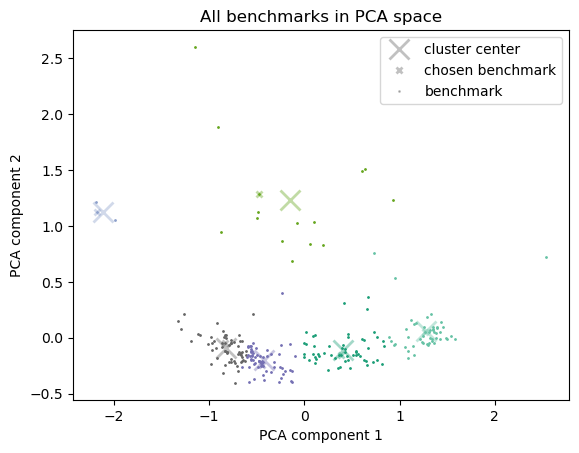

In [411]:
import matplotlib.pyplot
%matplotlib inline
pred = ClusteringSystemPredictor(6, False, False)
pred.select_benchmarks(systems_by_benchmarks, benchmarks_by_features)
fig =  matplotlib.pyplot.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("All benchmarks in PCA space")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
pred.plot(ax)

# Let's play the new benchmark game

- **Given** the statistical features of a new workload
- **Predict** the workload's log slowdown ratio

In [297]:
class NewBenchmarkPredictor(abc.ABC):
    @abc.abstractmethod
    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark
        new_benchmarks_by_features: an array where the (k,m)th element is the mth feature of the kth new benchmark

        returns a tuple containing:
          - an array where the kth element is the log slowdown of the kth *new* benchmark
          - the log-liklihood
        
        """
        pass

    @abc.abstractmethod
    def get_important_features(self) -> list[int]:
        """
        Returns a list of features this predictor feels are "important"

        This is optional, just for interpretability of results.
        """

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

In [317]:
def test_benchmark_predictors(
    predictors: list[NewBenchmarkPredictor],
) -> None:
    benchmarks = list(range(n_benchmarks))
    test_size = 0.1
    cv_splitter = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=test_size, random_state=0)
    for predictor in predictors:
        results = []
        important_features = collections.Counter()
        for train_benchmarks, test_benchmarks in cv_splitter.split(benchmarks):
            predicted, _ = predictor.predict_new_benchmark(
                systems_by_benchmarks[:, train_benchmarks],
                benchmarks_by_features[train_benchmarks, :],
                benchmarks_by_features[test_benchmarks, :],
            )
            for important_feature in predictor.get_important_features():
                important_features[important_feature] += 1
            actual = systems_by_benchmarks[:, test_benchmarks]
            results.append(root_mean_squared_error(actual, predicted))
        result_mean = numpy.mean(results)
        result_std = numpy.std(results)
        _, log_likelihood = predictor.predict_new_benchmark(systems_by_benchmarks, benchmarks_by_features, benchmarks_by_features)
        n_datapoints = len(systems_by_benchmarks.flatten()) + len(benchmarks_by_features.flatten())
        params = predictor.n_parameters()
        my_aicc = aicc(params, log_likelihood, n_datapoints)
        print(
            f"{result_mean: 5.2f}",
            f"{result_std: 5.2f}",
            f"{log_likelihood: 7.1f}",
            f"{params: 4d}",
            f"{my_aicc: 9.2f}",
            predictor,
            {feature_names[feature]: count for feature, count in important_features.most_common()},
        )

In [318]:
import scipy.linalg.interpolative

class Regression(NewBenchmarkPredictor):
    """
    This method simply regresses performance on the set of passed features.

    None means all.

    No linear method should be able to do better in RMSE, but dimensionality reduction may help with AIC.

    Note that the cross-validation score will be overestimated,
    because "variable selection" is not being re-evaluated strictly on the training set.
    """
    def __init__(self, features: list[int] | None) -> None:
        self.pre_features = features

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        self.features = self.pre_features if self.pre_features is not None else list(range(benchmarks_by_features.shape[1]))
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks,
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def get_important_features(self) -> list[int]:
        return self.features

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.features!r})"

In [319]:
import scipy.linalg.interpolative

class LowRankMatrixFactorization(NewBenchmarkPredictor):
    """
    Like Regression, but use a low-rank compression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.a.flatten()) + len(self.b.flatten()) + 1

    def get_important_features(self) -> list[int]:
        coeffs = self.a @ self.b
        feature_importance = numpy.fabs(coeffs.sum(axis=0))
        normed_feature_importance = feature_importance / feature_importance.sum()
        return [
            feature
            for feature, importance in enumerate(normed_feature_importance)
            if importance > 0.2
        ]

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        tmp = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features.T)
        u, s, vh = numpy.linalg.svd(tmp, full_matrices=False)
        self.a = (u[:, :self.dim] * s[:self.dim])
        self.b = vh[:self.dim, :]
        log_likelihood = naive_log_likelihood(
            self.a @ self.b @ benchmarks_by_features.T,
            systems_by_benchmarks,
        )
        return self.a @ self.b @ new_benchmarks_by_features.T, log_likelihood

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.dim})"

In [320]:
import scipy.linalg.interpolative

class GreedySubsetMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries to select only dim features.

    This is subtly different from "compressing to a matrix of rank dim".

    Using only dim features, means the other coefficients **have to be** zero.

    It's greedy because it picks the best feature, and adds next best given the current set, etc.
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        selected_features = []
        while len(selected_features) < self.dim:
            unselected_features = [
                feature
                for feature in range(benchmarks_by_features.shape[1])
                if feature not in selected_features
            ]
            selected_features = min([
                selected_features + [candidate_feature]
                for candidate_feature in unselected_features
            ], key=test_goodness)
        self.features = selected_features
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.dim})"

In [321]:
import random

class BestOfNMatrixFactorization(NewBenchmarkPredictor):
    """
    This method tries `iters` feature subsets, selecting the best.
    """
    def __init__(self, dim: int, iters: int) -> None:
        self.dim = dim
        self.iters = iters

    def n_parameters(self) -> int:
        return len(self.systems_by_features.flatten()) + 1

    def get_important_features(self) -> list[int]:
        return self.features

    def predict_new_benchmark(
        self,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[numpy.typing.NDArray, numpy.float64]:
        def test_goodness(features: list[int]) -> numpy.float64:
            systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, features].T)
            return numpy.sum((systems_by_features @ benchmarks_by_features[:, features].T - systems_by_benchmarks)**2)
        rng = random.Random(0)
        best_feature_set = None
        best_feature_score = None
        features = list(range(benchmarks_by_features.shape[1]))
        for _ in range(self.iters):
            feature_set = rng.sample(features, self.dim)
            score = test_goodness(feature_set)
            if best_feature_score is None or score < best_feature_score:
                best_feature_score = score
                best_feature_set = feature_set
        self.features = best_feature_set
        self.systems_by_features = systems_by_benchmarks @ numpy.linalg.pinv(benchmarks_by_features[:, self.features].T)
        log_likelihood = naive_log_likelihood(
            self.systems_by_features @ benchmarks_by_features[:, self.features].T,
            systems_by_benchmarks
        )
        return self.systems_by_features @ new_benchmarks_by_features[:, self.features].T, log_likelihood

    def __str__(self) -> str:
        return f"{self.__class__.__name__}({self.dim}, {self.iters})"

In [322]:
test_benchmark_predictors([
    Regression(None),
    Regression([feature_names.index("cputime_per_sec")]),
    Regression([feature_names.index("chmod_syscalls_per_sec")]),
    *[
        LowRankMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        GreedySubsetMatrixFactorization(i)
        for i in range(1, n_features + 1)
    ],
    *[
        BestOfNMatrixFactorization(i, 100)
        for i in range(1, n_features + 1)
    ]
])

 0.59  0.33  1012.0   66  -1891.91 Regression([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) {'cputime_per_sec': 10, 'memory_mean': 10, 'socket_syscalls_per_sec': 10, 'metadata_syscalls_per_sec': 10, 'chmod_syscalls_per_sec': 10, 'dir_syscalls_per_sec': 10, 'file_syscalls_per_sec': 10, 'exec_syscalls_per_sec': 10, 'clone_syscalls_per_sec': 10, 'exits_syscalls_per_sec': 10, 'dups_syscalls_per_sec': 10, 'other_syscalls_per_sec': 10, 'n_ops_per_sec': 10}
 0.49  0.09   813.7    6  -1615.49 Regression([0]) {'cputime_per_sec': 10}
 0.75  0.09   277.3    6   -542.68 Regression([4]) {'chmod_syscalls_per_sec': 10}
 0.60  0.31   889.5   19  -1741.04 LowRankMatrixFactorization(1) {'cputime_per_sec': 10}
 0.59  0.31   963.7   37  -1853.35 LowRankMatrixFactorization(2) {'cputime_per_sec': 10}
 0.60  0.33   994.9   55  -1879.85 LowRankMatrixFactorization(3) {'cputime_per_sec': 10}
 0.59  0.33  1012.0   73  -1877.91 LowRankMatrixFactorization(4) {'cputime_per_sec': 10}
 0.59  0.33  1012.0   91  -1841.91

# What about new-system-and-benchmark?

- **Given** integer N and workloads x benchmark matrix
- **Select** N workloads
- **Given** new system's log slowdown ratio on N selected workloads and features of new workload
- **Predict** new system's log slowdown ratio on new workload

Not implemented yet. Maybe won't be ever. Who would be picking a new system and new benchmark at the same time?

In [276]:
# Ignore this clase

class NewSystemAndBenchmarkProblem(abc.ABC):

    @abc.abstractmethod
    def select_benchmarks(
        self,
        k: int,
        systems_by_benchmarks: numpy.typing.NDArray,
        benchmarks_by_features: numpy.typing.NDArray,
    ) -> tuple[list[int], numpy.float64]:
        """
        k: number of benchmarks to select
        systems_by_benchmarks: array where the (i,j)th element is the log of the ith system's slowdown on the jth benchmark
        benchmarks_by_features: array where the (j,m)th element is the mth feature of the jth benchmark


        returns a tuple containing:
          - k benchmarks to select
          - the log-liklihood
        
        Liklihood is the probability of observing this data given the parameters you inferred
        Used to compute the Akaike Information Criterion.
        Return numpy.NaN if you just don't care.     
        """
        pass

    @abc.abstractmethod
    def n_parameters(self) -> int:
        """
        Returns the number of parameters used to make this estimation.
        Used to calculate the Akaike Information Criterion.
        """

    @abc.abstractmethod
    def predict_new_system_on_new_benchmarks(
        self,
        new_system_by_selected_benchmarks: numpy.typing.NDArray,
        selected_benchmarks_by_features: numpy.typing.NDArray,
        new_benchmarks_by_features: numpy.typing.NDArray,
    ) -> numpy.typing.NDArray:
        """
        new_system_by_selected_benchmarks: array where the qth element is the log of the new system's slowdown on the qth selected benchmark
        selected_benchmarks_by_features: array where the (q,m)th element is the mth feature of the qth selected benchmark
        new_benchmarks_by_features: array where the (p,m)th element is the mth feature of the pth new benchmark

        returns an array where the pth element is the log slowdown of the new system on the pth new benchmark
        """
        pass